In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
import os
import random
import numpy as np
import torch

def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    # For newer PyTorch versions that require this for full determinism
    if hasattr(torch, 'use_deterministic_algorithms'):
        torch.use_deterministic_algorithms(True)
    elif hasattr(torch, 'set_deterministic'): # For older PyTorch versions
        torch.set_deterministic(True)

    # Set PyTorch's random number generator seed for model weight initialization
    torch.nn.init.calculate_gain('leaky_relu', 0.2)

    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8' # Or :16:8, check your PyTorch version docs if issues
    os.environ['TORCH_CUDNN_V8_API_ENABLED'] = '1'
    print(f"All random seeds set to {seed} for reproducibility")

    # Reset RNG states to ensure consistency
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

SEED = 42 # From your best sweep config/script defaults
set_seed(SEED)

All random seeds set to 42 for reproducibility


# Glare Removal Dataset Exploration and Preprocessing

1. **Explored the dataset structure** - Examined the concatenated image format with ground truth, glared image, and glare mask
2. **Verified image dimensions** - Ensured all images have consistent dimensions
3. **Analyzed pixel distributions** - Studied the intensity distribution of both ground truth and glared images
4. **Implemented preprocessing** - Built preprocessing functions based on the project requirements 
5. **Created an optimized dataset class** - Implemented memory caching and efficient data handling
6. **Set up complete dataloaders** - Created reproducible dataloaders with augmentation for training

The preprocessing pipeline follows these key steps:
- Split concatenated images into components
- Convert to grayscale for simpler model training
- Resize to a consistent size (256×256)
- Normalize pixel values to [0,1] range
- Apply data augmentation for training
- Implement memory caching for performance optimization

This preparation enables efficient model training for the glare removal task.

In [4]:
# Set paths to data directories
train_dir = "SD1/train"
val_dir = "SD1/val"

# List all image files in both directories
train_images = [os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
val_images = [os.path.join(val_dir, f) for f in os.listdir(val_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print(f"Number of training images: {len(train_images)}")

Number of training images: 12000


## Exploratory Data Analysis

Let's examine the dataset structure and verify image dimensions.

In [5]:
# Function to display the triplet structure: [Ground Truth | Glared Image | Glare Mask]
def display_triplet(image_path):
    img = Image.open(image_path)
    img = np.array(img)

    # Split the concatenated image
    width = img.shape[1]
    third = width // 3

    ground_truth = img[:, :third, :]          # Ground truth image
    glared_image = img[:, third:2*third, :]   # Glared image
    glare_mask = img[:, 2*third:, :]          # Glare mask

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(ground_truth)
    axes[0].set_title('Ground Truth')
    axes[0].axis('off')

    axes[1].imshow(glared_image)
    axes[1].set_title('Glared Image')
    axes[1].axis('off')

    axes[2].imshow(glare_mask)
    axes[2].set_title('Glare Mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return {
        'shape': img.shape,
        'dtype': img.dtype,
        'min_value': img.min(),
        'max_value': img.max(),
        'mean_value': img.mean()
    }

Sample 10476 - File: 08875.png


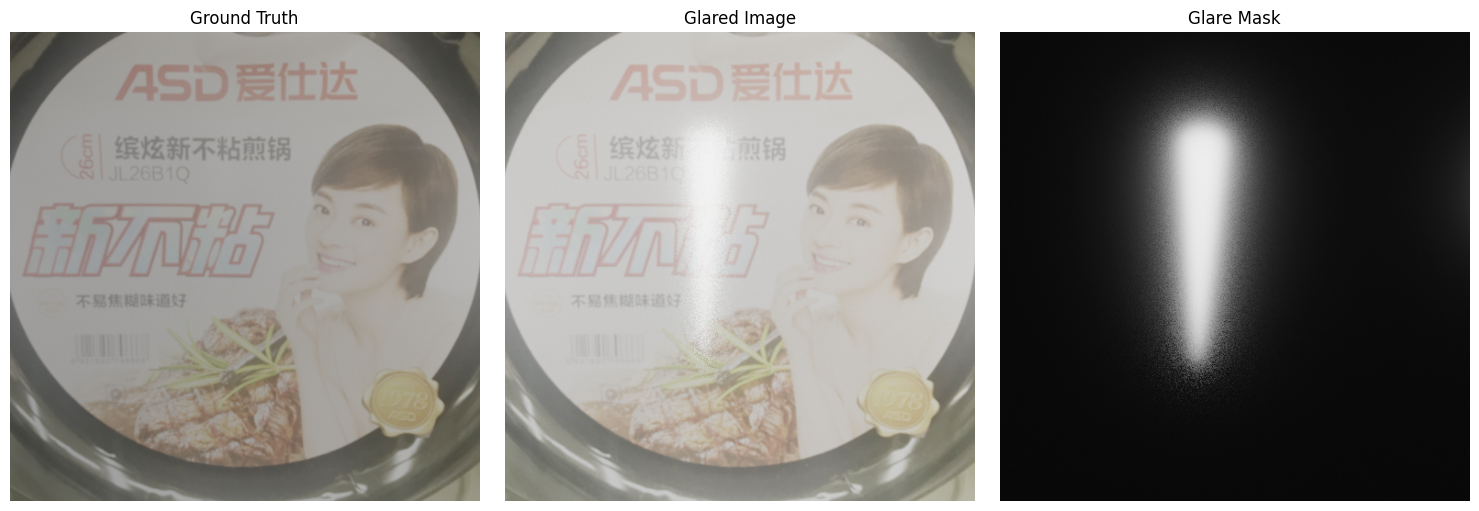

shape: (512, 1536, 4)
dtype: uint8
min_value: 8
max_value: 255
mean_value: 151.6206318537394
--------------------------------------------------
Sample 1824 - File: 07091.png


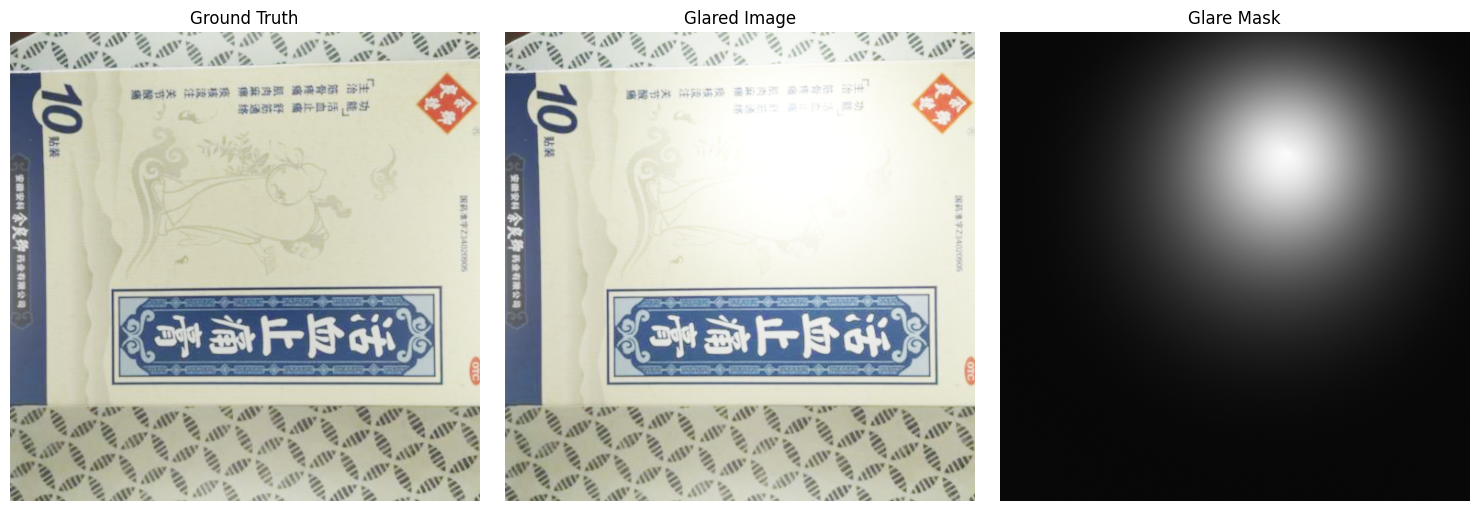

shape: (512, 1536, 4)
dtype: uint8
min_value: 7
max_value: 255
mean_value: 169.43563747406006
--------------------------------------------------
Sample 409 - File: 11369.png


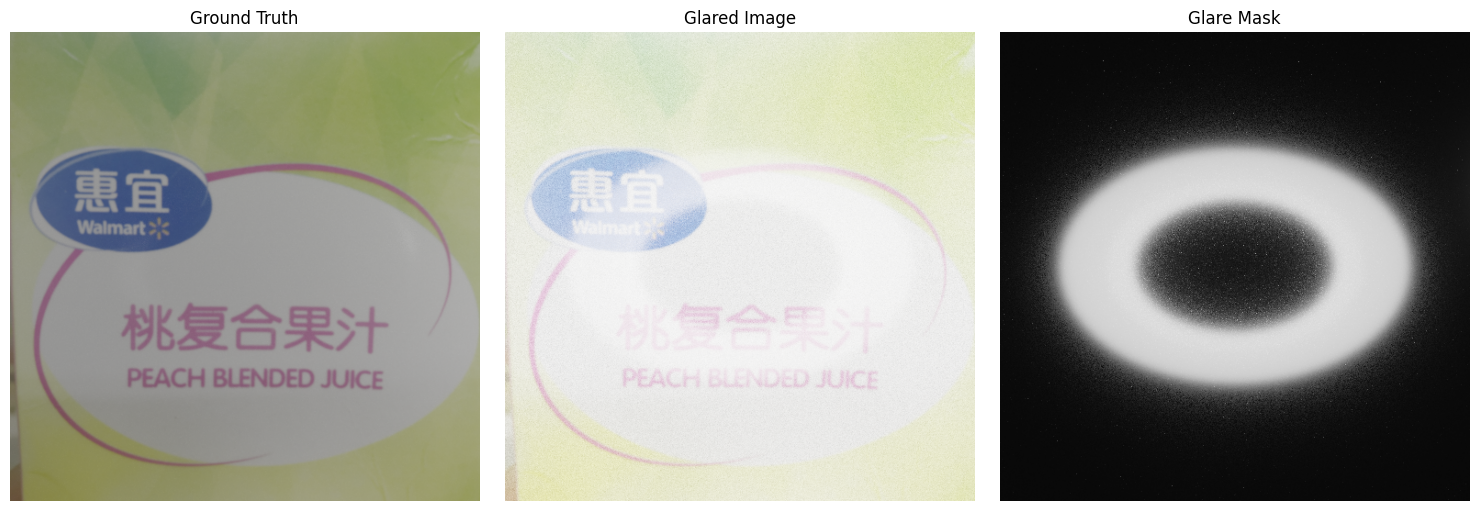

shape: (512, 1536, 4)
dtype: uint8
min_value: 8
max_value: 255
mean_value: 172.25880591074625
--------------------------------------------------


In [6]:
# Display a few random samples
import random
random.seed(42)  # For reproducibility
sample_indices = random.sample(range(len(train_images)), 3)

for idx in sample_indices:
    print(f"Sample {idx} - File: {os.path.basename(train_images[idx])}")
    stats = display_triplet(train_images[idx])
    for key, value in stats.items():
        print(f"{key}: {value}")
    print("-" * 50)

## Image Dimension Verification

Let's check if all images have the same dimensions.

In [7]:
# Function to check image dimensions
def check_image_dimensions(image_paths):
    dimensions = {}

    for path in tqdm(image_paths, desc="Checking dimensions"):
        try:
            img = Image.open(path)
            width, height = img.size
            dim_key = f"{width}x{height}"

            if dim_key in dimensions:
                dimensions[dim_key]['count'] += 1
                dimensions[dim_key]['files'].append(os.path.basename(path))
            else:
                dimensions[dim_key] = {
                    'count': 1,
                    'files': [os.path.basename(path)]
                }
        except Exception as e:
            print(f"Error processing {path}: {e}")

    return dimensions

# Check dimensions for training and validation sets
train_dimensions = check_image_dimensions(train_images)
val_dimensions = check_image_dimensions(val_images)

# Convert to DataFrames for better display
train_df = pd.DataFrame([
    {'Dimensions': dim, 'Count': data['count'], 'Percentage': 100 * data['count'] / len(train_images)}
    for dim, data in train_dimensions.items()
])

val_df = pd.DataFrame([
    {'Dimensions': dim, 'Count': data['count'], 'Percentage': 100 * data['count'] / len(val_images)}
    for dim, data in val_dimensions.items()
])

print("Training Image Dimensions:")
display(train_df)

print("\nValidation Image Dimensions:")
display(val_df)

Checking dimensions:   0%|          | 0/12000 [00:00<?, ?it/s]

Checking dimensions:   0%|          | 0/650 [00:00<?, ?it/s]

Training Image Dimensions:


Dimensions  Count  Percentage
0   1536x512  12000       100.0


Validation Image Dimensions:


Dimensions  Count  Percentage
0   1536x512    650       100.0

In [8]:
# Check if any non-standard dimensions exist
non_standard_dims = {}
for dim, data in train_dimensions.items():
    if data['count'] < len(train_images) * 0.1:  # Less than 10% of images
        non_standard_dims[dim] = data['files'][:5]  # Show first 5 files

for dim, data in val_dimensions.items():
    if data['count'] < len(val_images) * 0.1:  # Less than 10% of images
        non_standard_dims[dim] = data['files'][:5]  # Show first 5 files

if non_standard_dims:
    print("\nNon-standard dimensions detected:")
    for dim, files in non_standard_dims.items():
        print(f"{dim}: {', '.join(files)}{' and more...' if len(files) == 5 else ''}")

## Analysis of Pixel Value Distribution

Let's examine the intensity distribution of the ground truth and glared images.

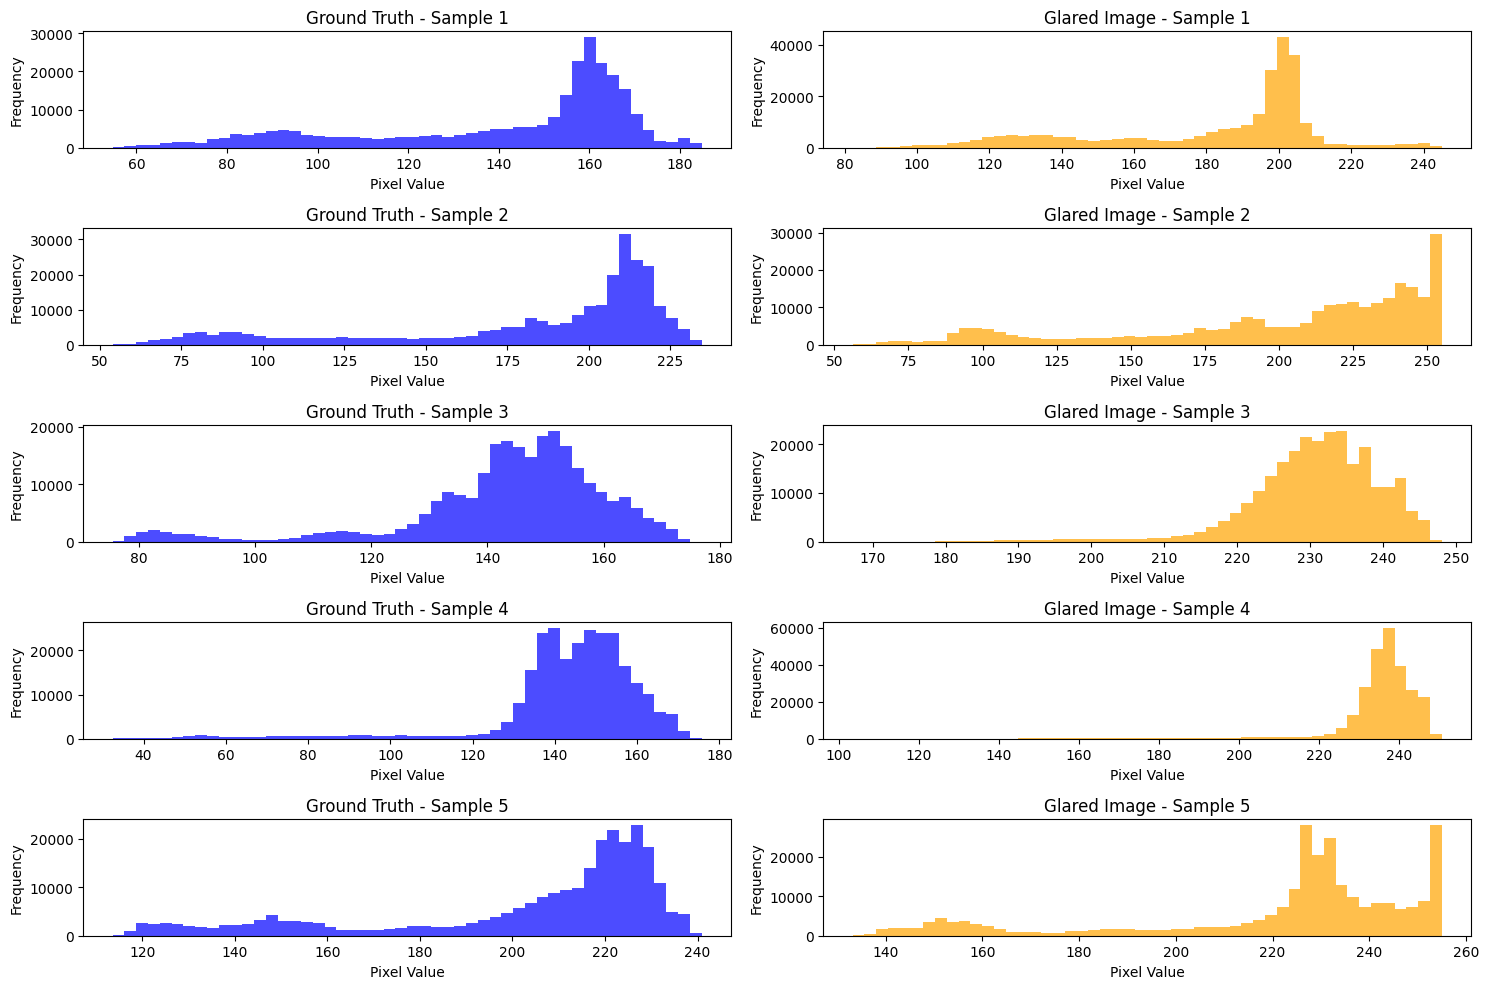

Ground Truth Mean  Ground Truth Std  Ground Truth Min  Ground Truth Max  \
0         141.530913         29.796252            54.729           184.772   
1         182.520101         44.784677            53.964           234.589   
2         143.509961         17.882358            75.492           176.886   
3         143.301079         19.158530            32.473           175.701   
4         202.866185         31.901300           113.583           240.886   

   Glared Image Mean  Glared Image Std  Glared Image Min  Glared Image Max  
0         181.845119         31.369018            82.202           245.000  
1         201.890418         50.023188            56.149           255.000  
2         230.581051          9.151780           167.270           248.000  
3         235.057428         12.388055           103.511           250.701  
4         221.265997         30.699406           133.137           255.000

Overall Statistics:
Ground Truth - Mean: 162.75, Std: 28.70
Glared Image - Mean: 214.13, Std: 26.73


In [9]:
def analyze_pixel_distribution(image_paths, num_samples=5):
    # Randomly select images
    random.seed(42)
    samples = random.sample(image_paths, min(num_samples, len(image_paths)))

    histograms = {'ground_truth': [], 'glared_image': []}

    plt.figure(figsize=(15, 10))

    for i, path in enumerate(samples):
        img = Image.open(path)
        img = np.array(img)

        # Split the concatenated image
        width = img.shape[1]
        third = width // 3

        ground_truth = img[:, :third, :]
        glared_image = img[:, third:2*third, :]

        # Convert to grayscale
        ground_truth_gray = 0.299 * ground_truth[:,:,0] + 0.587 * ground_truth[:,:,1] + 0.114 * ground_truth[:,:,2]
        glared_image_gray = 0.299 * glared_image[:,:,0] + 0.587 * glared_image[:,:,1] + 0.114 * glared_image[:,:,2]

        # Plot histograms
        plt.subplot(num_samples, 2, 2*i+1)
        plt.hist(ground_truth_gray.flatten(), bins=50, alpha=0.7, color='blue')
        plt.title(f'Ground Truth - Sample {i+1}')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')

        plt.subplot(num_samples, 2, 2*i+2)
        plt.hist(glared_image_gray.flatten(), bins=50, alpha=0.7, color='orange')
        plt.title(f'Glared Image - Sample {i+1}')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')

        # Store data for statistical analysis
        histograms['ground_truth'].append(ground_truth_gray.flatten())
        histograms['glared_image'].append(glared_image_gray.flatten())

    plt.tight_layout()
    plt.show()

    # Calculate and display statistics
    stats = {
        'ground_truth': {
            'mean': [np.mean(hist) for hist in histograms['ground_truth']],
            'std': [np.std(hist) for hist in histograms['ground_truth']],
            'min': [np.min(hist) for hist in histograms['ground_truth']],
            'max': [np.max(hist) for hist in histograms['ground_truth']]
        },
        'glared_image': {
            'mean': [np.mean(hist) for hist in histograms['glared_image']],
            'std': [np.std(hist) for hist in histograms['glared_image']],
            'min': [np.min(hist) for hist in histograms['glared_image']],
            'max': [np.max(hist) for hist in histograms['glared_image']]
        }
    }

    stats_df = pd.DataFrame({
        'Ground Truth Mean': stats['ground_truth']['mean'],
        'Ground Truth Std': stats['ground_truth']['std'],
        'Ground Truth Min': stats['ground_truth']['min'],
        'Ground Truth Max': stats['ground_truth']['max'],
        'Glared Image Mean': stats['glared_image']['mean'],
        'Glared Image Std': stats['glared_image']['std'],
        'Glared Image Min': stats['glared_image']['min'],
        'Glared Image Max': stats['glared_image']['max'],
    })

    display(stats_df)

    # Calculate overall statistics
    print("Overall Statistics:")
    print(f"Ground Truth - Mean: {np.mean(stats['ground_truth']['mean']):.2f}, Std: {np.mean(stats['ground_truth']['std']):.2f}")
    print(f"Glared Image - Mean: {np.mean(stats['glared_image']['mean']):.2f}, Std: {np.mean(stats['glared_image']['std']):.2f}")

# Analyze a subset of training images
analyze_pixel_distribution(train_images)

## Data Preprocessing Implementation

Now let's implement the preprocessing steps

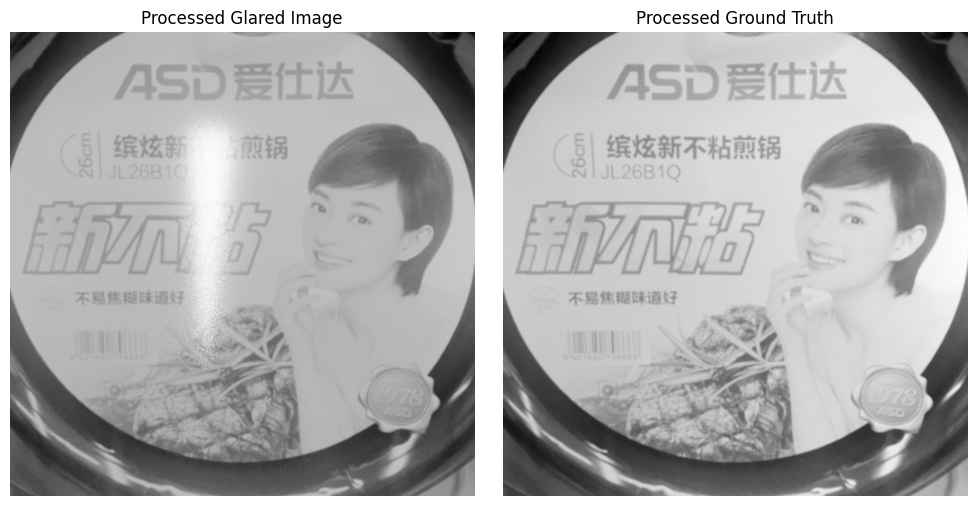

Glared Image Tensor Shape: torch.Size([1, 512, 512])
Glared Image Tensor Range: [0.3216, 0.9608]
Ground Truth Tensor Shape: torch.Size([1, 512, 512])
Ground Truth Tensor Range: [0.2157, 0.7255]


In [10]:
def preprocess_data(image_path, image_size=512):
    """
    Preprocess data from concatenated images in format [Ground Truth, Glared Image, Glare Mask]

    Args:
        image_path (str): Path to the image file
        image_size (int): Target image size

    Returns:
        tuple: Pair of tensors (glared_image, ground_truth)
    """
    # Load the image
    img = Image.open(image_path)
    img = np.array(img)

    # Split the concatenated image
    width = img.shape[1]
    third = width // 3

    ground_truth = img[:, :third, :]          # Ground truth image
    glared_image = img[:, third:2*third, :]   # Glared image
    # glare_mask = img[:, 2*third:, :]        # Glare mask (not used)

    # Convert to grayscale using OpenCV for better performance
    ground_truth_gray = cv2.cvtColor(ground_truth, cv2.COLOR_RGB2GRAY)
    glared_image_gray = cv2.cvtColor(glared_image, cv2.COLOR_RGB2GRAY)

    # Resize to target size if needed
    if ground_truth_gray.shape[0] != image_size or ground_truth_gray.shape[1] != image_size:
        ground_truth_gray = cv2.resize(ground_truth_gray, (image_size, image_size))
        glared_image_gray = cv2.resize(glared_image_gray, (image_size, image_size))

    # Normalize to [0, 1]
    ground_truth_gray = ground_truth_gray.astype(np.float32) / 255.0
    glared_image_gray = glared_image_gray.astype(np.float32) / 255.0

    # Convert to tensor
    ground_truth_tensor = torch.from_numpy(ground_truth_gray).unsqueeze(0)  # Add channel dimension
    glared_image_tensor = torch.from_numpy(glared_image_gray).unsqueeze(0)  # Add channel dimension

    return glared_image_tensor, ground_truth_tensor

# Test the preprocessing function on a sample image
random.seed(42)
sample_idx = random.choice(range(len(train_images)))
sample_path = train_images[sample_idx]

# Process the image
glared_tensor, ground_truth_tensor = preprocess_data(sample_path)

# Display the processed tensors
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(glared_tensor.squeeze().numpy(), cmap='gray')
axes[0].set_title('Processed Glared Image')
axes[0].axis('off')

axes[1].imshow(ground_truth_tensor.squeeze().numpy(), cmap='gray')
axes[1].set_title('Processed Ground Truth')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Print information about the tensors
print(f"Glared Image Tensor Shape: {glared_tensor.shape}")
print(f"Glared Image Tensor Range: [{glared_tensor.min():.4f}, {glared_tensor.max():.4f}]")
print(f"Ground Truth Tensor Shape: {ground_truth_tensor.shape}")
print(f"Ground Truth Tensor Range: [{ground_truth_tensor.min():.4f}, {ground_truth_tensor.max():.4f}]")

## Creating a Processed Dataset

Implement a complete pytorch dataset class and use albumentations for data augmentations

In [11]:
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

class GlareRemovalDataset(Dataset):
    """
    Dataset for glare removal task with optional memory caching and optimizations
    """
    def __init__(self, image_paths, transform=None, seed=None, image_size=256, cache_images=False):
        """
        Initialize the dataset with optional memory caching

        Args:
            image_paths (list): List of image file paths
            transform (albumentations.Compose): Transformations to apply
            image_size (int): Size to resize images to
            cache_images (bool): Whether to cache processed images in memory
        """
        self.image_paths = sorted(image_paths)  # Sort for consistency
        self.transform = transform
        self.seed = seed
        self.image_size = image_size
        self.cache_images = cache_images

        # Pre-process and cache images if enabled
        self.cached_images = {}
        if self.cache_images:
            self._cache_images()

    def _cache_images(self):
        """Pre-process and cache images for faster access during training"""
        print(f"Pre-processing and caching {len(self.image_paths)} images...")

        for i, path in enumerate(tqdm(self.image_paths, desc="Caching")):
            # Load and process the image
            img = cv2.imread(path)
            if img is None:
                print(f"Warning: Could not load image {path}, skipping")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Split the concatenated image
            width = img.shape[1]
            third = width // 3

            ground_truth = img[:, :third, :]
            glared_image = img[:, third:2*third, :]

            # Convert to grayscale
            ground_truth_gray = cv2.cvtColor(ground_truth, cv2.COLOR_RGB2GRAY)
            glared_image_gray = cv2.cvtColor(glared_image, cv2.COLOR_RGB2GRAY)

            # Resize to target size
            glared_image_gray = cv2.resize(glared_image_gray, (self.image_size, self.image_size))
            ground_truth_gray = cv2.resize(ground_truth_gray, (self.image_size, self.image_size))

            # Normalize to [0, 1]
            glared_image_gray = glared_image_gray.astype(np.float32) / 255.0
            ground_truth_gray = ground_truth_gray.astype(np.float32) / 255.0

            # Store in cache
            self.cached_images[i] = (glared_image_gray, ground_truth_gray)

        print(f"Completed caching {len(self.cached_images)} images")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # Set seed for reproducible augmentations
        if self.seed is not None:
            seed_for_augmentation = self.seed + index
            random.seed(seed_for_augmentation)
            np.random.seed(seed_for_augmentation)
            torch.manual_seed(seed_for_augmentation)

        # Use cached images if available
        if self.cache_images and index in self.cached_images:
            glared_image_gray, ground_truth_gray = self.cached_images[index]
        else:
            # Load and process image if not cached
            image_path = self.image_paths[index]

            # Load the image
            img = cv2.imread(image_path)
            if img is None:
                raise ValueError(f"Failed to load image: {image_path}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Split the concatenated image
            width = img.shape[1]
            third = width // 3

            ground_truth = img[:, :third, :]
            glared_image = img[:, third:2*third, :]

            # Convert to grayscale
            ground_truth_gray = cv2.cvtColor(ground_truth, cv2.COLOR_RGB2GRAY)
            glared_image_gray = cv2.cvtColor(glared_image, cv2.COLOR_RGB2GRAY)

            # Resize to target size
            glared_image_gray = cv2.resize(glared_image_gray, (self.image_size, self.image_size))
            ground_truth_gray = cv2.resize(ground_truth_gray, (self.image_size, self.image_size))

            # Normalize to [0, 1]
            glared_image_gray = glared_image_gray.astype(np.float32) / 255.0
            ground_truth_gray = ground_truth_gray.astype(np.float32) / 255.0

        # Apply transformations
        if self.transform:
            # Make sure masks are correctly transformed with the same augmentations
            augmented = self.transform(image=glared_image_gray, mask=ground_truth_gray)
            glared_image_tensor = augmented['image']  # Already a tensor from ToTensorV2
            ground_truth_tensor = augmented['mask']  # Already a tensor from ToTensorV2

            # Ensure channel dimension exists
            if len(ground_truth_tensor.shape) == 2:
                ground_truth_tensor = ground_truth_tensor.unsqueeze(0)
        else:
            # Convert to tensor
            glared_image_tensor = torch.from_numpy(glared_image_gray).unsqueeze(0)  # Add channel dimension
            ground_truth_tensor = torch.from_numpy(ground_truth_gray).unsqueeze(0)  # Add channel dimension

        return glared_image_tensor, ground_truth_tensor

# Create data augmentation transformations
def get_transformations(image_size=512, seed=42):
    """
    Get data augmentation transformations for training and validation

    Args:
        image_size (int): Size of images for training
        seed (int): Random seed for reproducibility

    Returns:
        tuple: (train_transform, val_transform) for training and validation datasets
    """
    # Training transforms with augmentations
    train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.8),
            A.GaussNoise(p=0.2),
        ], p=0.5),
        ToTensorV2(),
    ], seed=seed)

    # Minimal validation transforms
    val_transform = A.Compose([
        ToTensorV2(),
    ], seed=seed)

    return train_transform, val_transform

/home/joozy/code/htx/ta-2025/.venv/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Creating and Testing the DataLoaders

Now let's create and test dataloaders for training and validation.

In [12]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# Get transformations
train_transform, val_transform = get_transformations(image_size=512, seed=seed)

# Create datasets
train_dataset = GlareRemovalDataset(
    train_images[:10],  # Using a subset for demonstration
    transform=train_transform,
    image_size=512,
    cache_images=True  # Enable caching
)

val_dataset = GlareRemovalDataset(
    val_images[:5],  # Using a subset for demonstration
    transform=val_transform,
    image_size=512,
    cache_images=True  # Enable caching
)

# Create dataloaders
batch_size = 4  # Small batch size for demonstration
num_workers = 2  # Adjust based on your system

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

# Test the dataloaders
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

# Get a batch of data
train_inputs, train_targets = next(iter(train_loader))
print(f"Input batch shape: {train_inputs.shape}")
print(f"Target batch shape: {train_targets.shape}")

Pre-processing and caching 10 images...


Caching:   0%|          | 0/10 [00:00<?, ?it/s]

Completed caching 10 images
Pre-processing and caching 5 images...


Caching:   0%|          | 0/5 [00:00<?, ?it/s]

Completed caching 5 images
Number of training batches: 3
Number of validation batches: 2
Input batch shape: torch.Size([4, 1, 512, 512])
Target batch shape: torch.Size([4, 1, 512, 512])


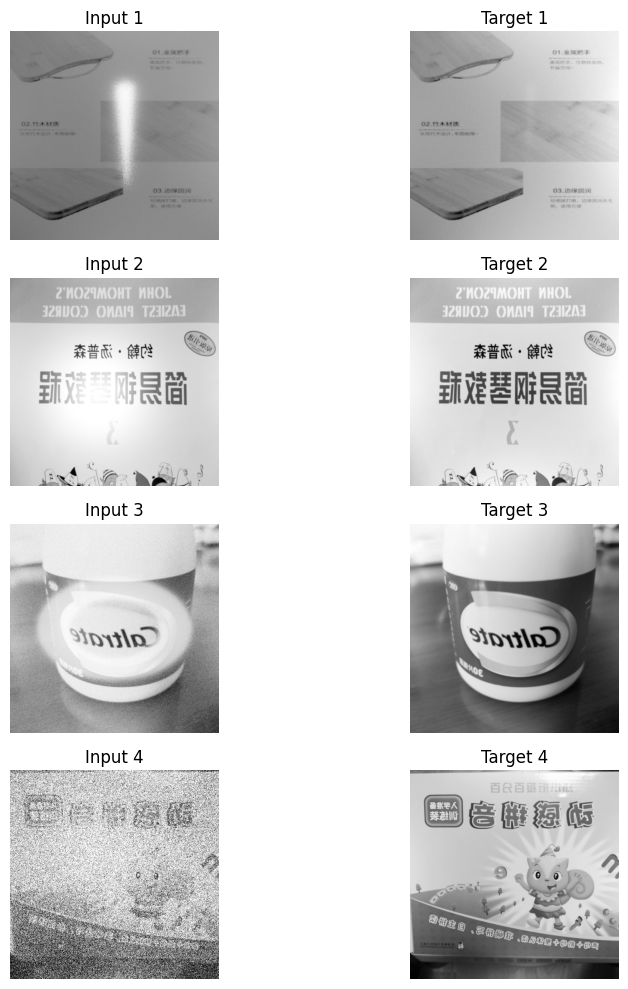

In [13]:
# Visualize a batch
fig, axes = plt.subplots(batch_size, 2, figsize=(10, 10))

for i in range(batch_size):
    # Display input image
    axes[i, 0].imshow(train_inputs[i, 0].numpy(), cmap='gray')
    axes[i, 0].set_title(f'Input {i+1}')
    axes[i, 0].axis('off')

    # Display target image
    axes[i, 1].imshow(train_targets[i, 0].numpy(), cmap='gray')
    axes[i, 1].set_title(f'Target {i+1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

## Complete Preprocessing Pipeline

Finally, let's create a complete function that creates dataloaders for the full dataset.

In [14]:
def seed_worker(worker_id):
    """Set random seed for dataloader workers to ensure reproducibility"""
    # Use a combination of the main seed and worker_id to ensure diversity
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def create_dataloaders(data_dir, batch_size=4, val_split=0.2, num_workers=4,
                                    seed=42, image_size=512, cache_images=False,
                                    prefetch_factor=2, persistent_workers=True): # Added new params
    """
    Create training and validation dataloaders with reproducibility in mind.
    Matches create_optimized_dataloaders more closely.
    """

    image_paths = []
    for root, _, files in os.walk(data_dir): # Recursive search
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))

    image_paths.sort() # Sort before shuffling

    # Reproducible shuffle and split
    rng = np.random.RandomState(seed)
    rng.shuffle(image_paths)

    split_idx = int(len(image_paths) * (1 - val_split))
    train_images = image_paths[:split_idx]
    val_images = image_paths[split_idx:]

    # Get transformations
    train_transform, val_transform = get_transformations(image_size, seed)

    # Create datasets
    train_dataset = GlareRemovalDataset(
        train_images,
        transform=train_transform,
        image_size=image_size,
        cache_images=cache_images,
        seed=seed
    )

    val_dataset = GlareRemovalDataset(
        val_images,
        transform=val_transform,
        image_size=image_size,
        cache_images=cache_images,
        seed=seed
    )

    # Create generators for dataloaders
    g_train = torch.Generator()
    g_train.manual_seed(seed)
    g_val = torch.Generator()
    g_val.manual_seed(seed + 1) # Different seed for validation generator

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker, # ADDED
        generator=g_train,         # ADDED
        prefetch_factor=prefetch_factor if num_workers > 0 else None, # ADDED
        persistent_workers=persistent_workers if num_workers > 0 else False # ADDED
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=max(1, num_workers // 2), # Use fewer workers for val like in script
        pin_memory=True,
        worker_init_fn=seed_worker, # ADDED
        generator=g_val,           # ADDED
        prefetch_factor=prefetch_factor if num_workers > 0 else None, # ADDED
        persistent_workers=persistent_workers if num_workers > 0 else False # ADDED
    )

    print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
    print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")

    return train_loader, val_loader

# Model

The model is a specialized U-Net architecture that follows the encoder-decoder pattern with skip connections, optimized for removing glare from images.

**What kind of task is this?**

- This is an image restoration/enhancement task, specifically deglaring. It falls under the category of image-to-image translation or dense pixel-wise regression, where each
input pixel is transformed to produce a cleaned output pixel.

**What kind of pattern is a model required to learn?**

- The model needs to learn to identify glare patterns in images and restore the underlying content. It must understand how light interacts with surfaces and creates unwanted
reflections, then predict what the image would look like without these artifacts.

**What kind of models are suited for this task?**

- Encoder-decoder architectures with skip connections like U-Net are ideal for this task because:
  - They capture both local and global context
  - They preserve spatial information critical for restoration
  - They can transform images while maintaining structural details

- Generative models:
  - GANs like Pix2Pix, CycleGAN
  - Diffusion models adapted for restoration

**What kind of model have we chosen?**

An optimized U-Net model with several efficiency enhancements:
- Reduced depth (fewer layers)
- Lower channel counts
- Group normalization instead of batch normalization
- Channel attention mechanisms (SE-inspired blocks)
- SiLU (Swish) activation functions
- Nearest neighbor upsampling rather than transposed convolutions

**How the model works**

1. Encoder Path: Progressively downsamples the image through four encoding blocks, each reducing spatial dimensions while increasing feature channels (16→32→64→128→256)
2. Bottleneck: Captures the most abstract representations at the lowest resolution
3. Attention Mechanisms: Applies channel attention at each skip connection to highlight important features
4. Decoder Path: Progressively upsamples and combines features from the encoder through skip connections
5. Skip Connections: Allow high-resolution details from earlier layers to be combined with semantic information from deeper layers

**How this model helps with the deglaring task**

This model is well-suited for deglaring because:

1. The U-Net architecture allows it to capture both fine details and broader context needed to distinguish between actual image content and glare artifacts
2. Channel attention helps focus on the most relevant features for restoration
3. The skip connections preserve important structural details that might be lost during downsampling
4. The optimizations make it computationally efficient while maintaining restoration quality
5. The model learns the inverse function of the glare process, effectively recovering the clean latent image from a glared input

In [15]:
import torch
import torch.nn as nn

class LightweightUNet(nn.Module):
    """
    Lightweight U-Net architecture with GroupNorm for image de-glaring.
    Designed for grayscale images.
    """
    def __init__(self, in_channels=1, out_channels=1, num_groups=8, features_start=8):
        """
        Initialize the lightweight U-Net model.

        Args:
            in_channels (int): Number of input channels (1 for grayscale).
            out_channels (int): Number of output channels (1 for grayscale).
            num_groups (int): Number of groups for GroupNorm.
                               Ensure this divides the feature channels at each stage,
                               or adjust logic in _block for small channel counts.
                               A common value is 8 or 16 or 32.
            features_start (int): Number of features in the first encoder block.
                                  Subsequent blocks will double this.
        """
        super().__init__()
        self.num_groups = num_groups

        f = [features_start, features_start*2, features_start*4, features_start*8, features_start*16]

        # Encoder (downsampling)
        self.enc1 = self._block(in_channels, f[0])
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.enc2 = self._block(f[0], f[1])
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.enc3 = self._block(f[1], f[2])
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.enc4 = self._block(f[2], f[3])
        self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = self._block(f[3], f[4])

        # Decoder (upsampling)
        self.upconv4 = nn.ConvTranspose2d(f[4], f[3], kernel_size=2, stride=2)
        self.dec4 = self._block(f[3] * 2, f[3])  # Concatenation: f[3] (from upconv) + f[3] (from enc4)
        self.upconv3 = nn.ConvTranspose2d(f[3], f[2], kernel_size=2, stride=2)
        self.dec3 = self._block(f[2] * 2, f[2])
        self.upconv2 = nn.ConvTranspose2d(f[2], f[1], kernel_size=2, stride=2)
        self.dec2 = self._block(f[1] * 2, f[1])
        self.upconv1 = nn.ConvTranspose2d(f[1], f[0], kernel_size=2, stride=2)
        self.dec1 = self._block(f[0] * 2, f[0])

        # Output layer
        self.output_conv = nn.Conv2d(f[0], out_channels, kernel_size=1)

    def _block(self, in_channels, features):
        """
        Create a convolutional block for the U-Net with GroupNorm.

        Args:
            in_channels (int): Number of input channels.
            features (int): Number of output channels for this block.

        Returns:
            nn.Sequential: Sequential container of layers.
        """
        # Ensure num_groups is appropriate for the number of features
        # If features are less than num_groups, or not divisible,
        # GroupNorm might behave like InstanceNorm or LayerNorm depending on num_groups.
        # A common strategy is to use min(self.num_groups, features) if features is small.
        # Or ensure features is always a multiple of num_groups.
        # For simplicity here, we assume num_groups is chosen appropriately.
        # If features < self.num_groups, you might want to set gn_groups = features
        # or ensure features is always >= self.num_groups and divisible.

        # A robust way to set num_groups for GN:
        current_num_groups = self.num_groups
        if features < self.num_groups : # e.g. features = 8, num_groups = 32
            current_num_groups = features # each channel its own group (like InstanceNorm if groups=features)
                                     # or 1 (like LayerNorm if groups=1)
                                     # A common choice is to ensure features % current_num_groups == 0
                                     # Let's find largest divisor for features that is <= self.num_groups
            for i in range(min(self.num_groups, features), 0, -1):
                if features % i == 0:
                    current_num_groups = i
                    break
        elif features % self.num_groups != 0:
             # Find largest divisor for features that is <= self.num_groups
            for i in range(self.num_groups, 0, -1):
                if features % i == 0:
                    current_num_groups = i
                    break

        # If features_start is small (e.g. 8) and num_groups is also small (e.g. 8),
        # current_num_groups will be 8, which is fine.
        # If features_start=8, num_groups=32, then current_num_groups will be 8.

        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(num_groups=current_num_groups, num_channels=features),
            nn.SiLU(inplace=True), # SiLU (Swish) is a good modern activation
            nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(num_groups=current_num_groups, num_channels=features),
            nn.SiLU(inplace=True)
        )

    def forward(self, x):
        """
        Forward pass through the network.
        """
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))

        # Decoder with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        out = self.output_conv(dec1)

        return out

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class OptimizedUNet(nn.Module):
    """
    Optimized U-Net architecture for image de-glaring

    Features:
    - Reduced depth (fewer layers)
    - Fewer channels in each layer
    - No 5th encoder/decoder block (vs enhanced model)
    - Simplified attention mechanism
    - Group normalization instead of batch normalization
    - EfficientNet-inspired squeeze-and-excitation blocks
    """
    def __init__(self, in_channels=1, out_channels=1):
        """
        Initialize the optimized U-Net model

        Args:
            in_channels (int): Number of input channels (1 for grayscale)
            out_channels (int): Number of output channels (1 for grayscale)
        """
        super().__init__()

        # Initial feature dimensions
        self.init_features = 16

        # Encoder (downsampling)
        self.enc1 = self._block(in_channels, self.init_features, groups=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # AvgPool is faster than MaxPool

        self.enc2 = self._block(self.init_features, self.init_features*2)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.enc3 = self._block(self.init_features*2, self.init_features*4)
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.enc4 = self._block(self.init_features*4, self.init_features*8)
        self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(self.init_features*8, self.init_features*16, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(8, self.init_features*16),
            nn.SiLU(inplace=True),  # SiLU (Swish) is more efficient than ReLU
            nn.Conv2d(self.init_features*16, self.init_features*16, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(8, self.init_features*16),
            nn.SiLU(inplace=True)
        )

        # Attention blocks - simplified
        self.attention4 = ChannelAttention(self.init_features*8)
        self.attention3 = ChannelAttention(self.init_features*4)
        self.attention2 = ChannelAttention(self.init_features*2)
        self.attention1 = ChannelAttention(self.init_features)

        # Decoder (upsampling) - Simplified to use nearest interpolation
        self.upconv4 = self._upblock(self.init_features*16, self.init_features*8)
        self.dec4 = self._block(self.init_features*16, self.init_features*8)

        self.upconv3 = self._upblock(self.init_features*8, self.init_features*4)
        self.dec3 = self._block(self.init_features*8, self.init_features*4)

        self.upconv2 = self._upblock(self.init_features*4, self.init_features*2)
        self.dec2 = self._block(self.init_features*4, self.init_features*2)

        self.upconv1 = self._upblock(self.init_features*2, self.init_features)
        self.dec1 = self._block(self.init_features*2, self.init_features)

        # Output layer
        self.output = nn.Conv2d(self.init_features, out_channels, kernel_size=1)

    def _block(self, in_channels, features, groups=4):
        """
        Create an optimized convolutional block

        Args:
            in_channels (int): Number of input channels
            features (int): Number of output channels
            groups (int): Number of groups for GroupNorm

        Returns:
            nn.Sequential: Sequential container of layers
        """
        # Ensure groups isn't larger than features
        groups = min(groups, features)

        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(max(1, groups), features),  # GroupNorm is more efficient than BatchNorm
            nn.SiLU(inplace=True),  # SiLU (Swish) is more efficient than ReLU
            nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(max(1, groups), features),
            nn.SiLU(inplace=True)
        )

    def _upblock(self, in_channels, out_channels):
        """
        Create an upsampling block using interpolation (faster than ConvTranspose2d)

        Args:
            in_channels (int): Number of input channels
            out_channels (int): Number of output channels

        Returns:
            nn.Sequential: Sequential container for upsampling
        """
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(4, out_channels),
            nn.SiLU(inplace=True)
        )

    def forward(self, x):
        """
        Forward pass through the network

        Args:
            x (torch.Tensor): Input tensor of shape [B, C, H, W]

        Returns:
            torch.Tensor: Output tensor of shape [B, C, H, W]
        """
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))

        # Decoder with attention-enhanced skip connections
        dec4 = self.upconv4(bottleneck)
        enc4 = self.attention4(enc4)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        enc3 = self.attention3(enc3)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        enc2 = self.attention2(enc2)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        enc1 = self.attention1(enc1)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        return self.output(dec1)


class ChannelAttention(nn.Module):
    """
    Lightweight channel attention mechanism inspired by squeeze-and-excitation blocks
    Helps the model focus on relevant features with minimal computational overhead
    """
    def __init__(self, channels, reduction=16):
        """
        Initialize channel attention module

        Args:
            channels (int): Number of input channels
            reduction (int): Reduction ratio for the bottleneck
        """
        super(ChannelAttention, self).__init__()
        reduced_channels = max(channels // reduction, 8)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, reduced_channels, bias=False),
            nn.SiLU(inplace=True),
            nn.Linear(reduced_channels, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass

        Args:
            x (torch.Tensor): Input tensor [B, C, H, W]

        Returns:
            torch.Tensor: Attention-weighted input
        """
        b, c, _, _ = x.size()
        avg = self.avg_pool(x).view(b, c)

        # Channel attention weights
        weights = self.fc(avg).view(b, c, 1, 1)

        # Apply attention
        return x * weights

In [17]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model
# model = OptimizedUNet(in_channels=1, out_channels=1).to(device)
model = LightweightUNet(in_channels=1, out_channels=1).to(device)

# Display model size
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_model_size_mb(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    model_size = sum([p.numel() * p.element_size() for p in model_parameters])
    return model_size / (1024 * 1024)

params_count = count_parameters(model)
model_size = get_model_size_mb(model)
print(f"Total trainable parameters: {params_count:,}")
print(f"Model size: {model_size:.2f} MB")

# Check if model meets the size requirement
if model_size > 4.0:
    print("Warning: Model exceeds 4MB target size.")
else:
    print("Model size is within the 4MB target specification.")

# Show model summary
print(model)

Using device: cuda
Total trainable parameters: 486,409
Model size: 1.86 MB
Model size is within the 4MB target specification.
LightweightUNet(
  (enc1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): GroupNorm(8, 8, eps=1e-05, affine=True)
    (2): SiLU(inplace=True)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): GroupNorm(8, 8, eps=1e-05, affine=True)
    (5): SiLU(inplace=True)
  )
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (enc2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): GroupNorm(8, 16, eps=1e-05, affine=True)
    (2): SiLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): GroupNorm(8, 16, eps=1e-05, affine=True)
    (5): SiLU(inplace=True)
  )
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (enc3): Sequential(
    (0): Conv2d(

# Assumptions and Interpretations

1. Dataset Structure Assumptions:
  - Images are concatenated in format [Ground Truth, Glared Image, Glare Mask]
  - Each section occupies exactly 1/3 of the image width
  - RGBA format handling is implemented as specified in requirements
2. Model Architecture Decisions:
  - Custom U-Net architecture instead of using suggested pre-trained models
  - Optimized for small size (<4MB) while meeting L1 loss target
  - Focused on grayscale processing to reduce error as specified
3. Training Optimizations:
  - Mixed precision training for performance
  - Memory caching and image size reduction for faster training
  - Data Augmentations for better generalization
  - AdamW optimizer instead of standard Adam
4. Performance Considerations:
  - Group normalization instead of batch normalization for efficiency
  - Average pooling instead of max pooling for faster processing
  - SiLU activation function for better performance than ReLU
  - Extensive reproducibility measures with seed control
5. Evaluation Beyond Requirements:
  - Additional metrics (PSNR, SSIM) beyond required L1 loss
  - Wandb integration for experiment tracking

# Model Training

1. Initialization & Setup:
  - Sets reproducible seeds for consistent results
  - Configures CUDA for deterministic operation
  - Initializes data generators with specific seeds for reproducibility
2. Data Preparation:
  - Uses `create_dataloaders` to split and load training/validation data
  - Applies grayscale conversion and normalization
  - Implements caching for faster training
  - Uses separate worker processes with careful seed control
3. Model Creation:
  - Instantiates the OptimizedUNet with single input/output channels (grayscale)
  - Uses L1Loss criterion as specified in requirements
  - Configures AdamW optimizer with weight decay
4. Training Loop:
  - Runs for specified number of epochs with early stopping option
  - Uses mixed precision (automatic for CUDA) for faster training
  - Applies gradient scaling and clipping for stability
  - Tracks best model based on validation loss
5. Performance Optimizations:
  - Implements AMP (Automatic Mixed Precision) for faster training
  - Uses non-blocking tensor transfers to overlap computation
  - Sets zero_grad(set_to_none=True) for more efficient memory usage
6. Monitoring & Checkpoints:
  - Optional WandB integration for experiment tracking
  - Periodically logs sample images and validation metrics
  - Saves checkpoints at regular intervals
  - Tracks best model weights separately
7. Learning Rate Management:
  - Uses ReduceLROnPlateau scheduler to reduce learning rate when progress plateaus
  - Factor of 0.5 with patience of 5 epochs
8. Finalization:
  - Loads best weights before saving final model
  - Saves weights in multiple formats (checkpoint and weights-only)

In [18]:
train_loader, val_loader = create_dataloaders(
    data_dir="SD1/train", # Ensure this path leads to the same files as scripts
    batch_size=4, # Use your notebook's BATCH_SIZE
    val_split=0.2, # Match script
    num_workers=4, # Match script/config
    seed=SEED,     # Use your global SEED
    image_size=512, # Use your notebook's IMAGE_SIZE
    cache_images=False, # Match script default
    prefetch_factor=2, # Match script default
    persistent_workers=True # Match script default (if num_workers > 0)
)

Training samples: 9600, Validation samples: 2400
Training batches: 2400, Validation batches: 600


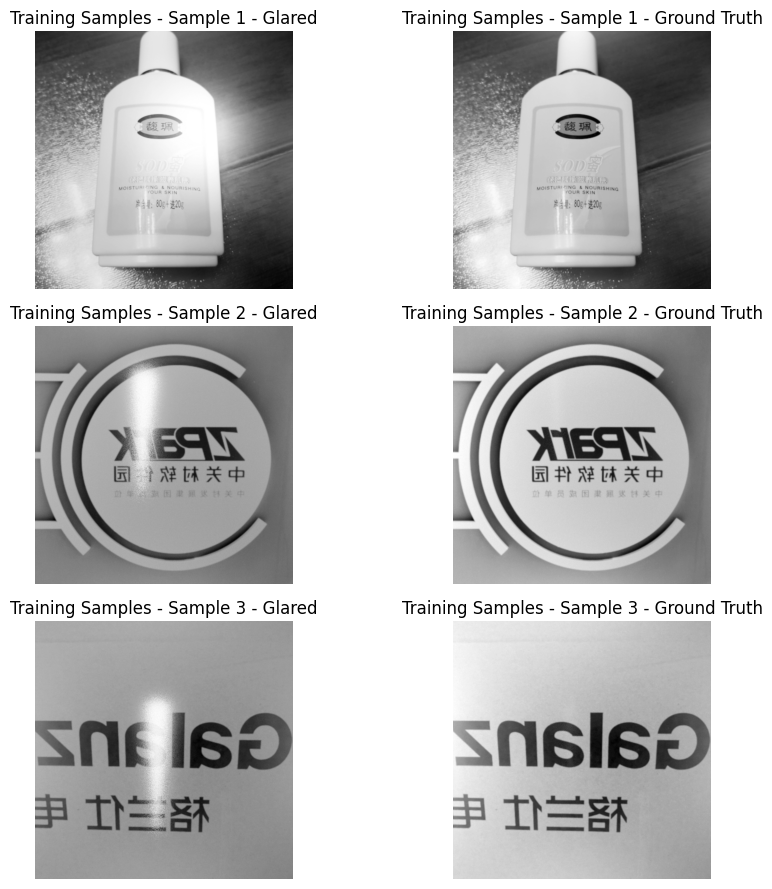


Training Samples Statistics:
Shapes: torch.Size([3, 1, 512, 512]), torch.Size([3, 1, 512, 512])
Value ranges - Glared: [0.25, 1.00], Ground Truth: [0.20, 0.93]


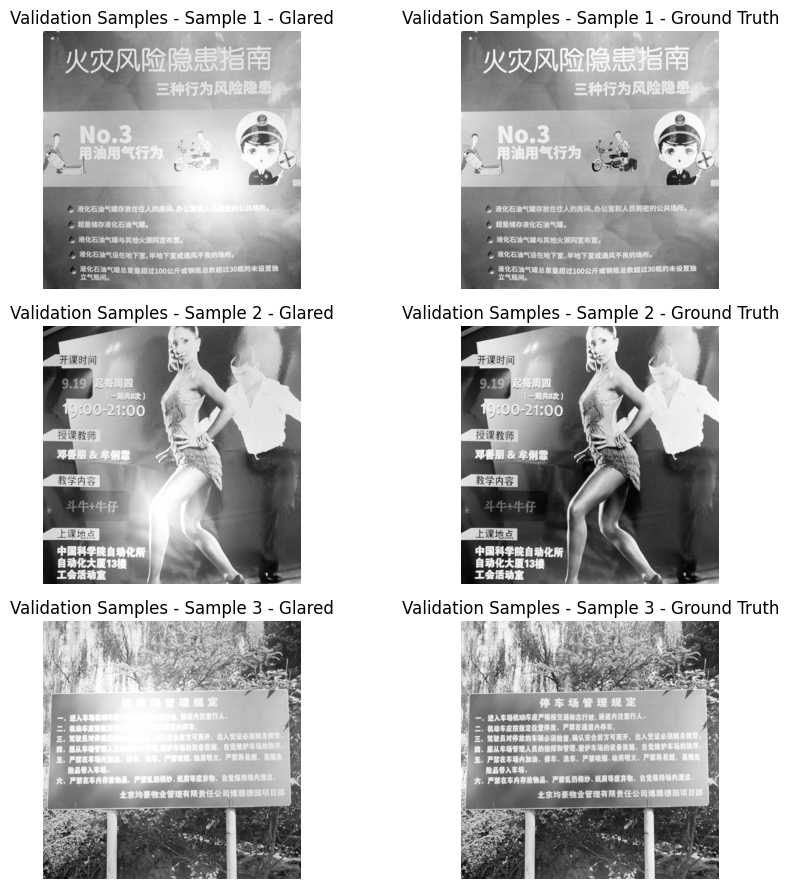


Validation Samples Statistics:
Shapes: torch.Size([3, 1, 512, 512]), torch.Size([3, 1, 512, 512])
Value ranges - Glared: [0.22, 1.00], Ground Truth: [0.19, 0.94]


In [19]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Get a single batch from each loader
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

# Display a few samples
def show_samples(batch, title, num_samples=3):
    glared_images, ground_truth = batch

    # Take only the first few samples
    glared_images = glared_images[:num_samples]
    ground_truth = ground_truth[:num_samples]

    # Denormalize (assuming mean=0.5, std=0.5 normalization)
    glared_np = glared_images.cpu().numpy() * 0.5 + 0.5
    ground_truth_np = ground_truth.cpu().numpy() * 0.5 + 0.5

    # Create figure
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 3*num_samples))

    for i in range(num_samples):
        # Display glared image
        axs[i, 0].imshow(glared_np[i, 0], cmap='gray')
        axs[i, 0].set_title(f"{title} - Sample {i+1} - Glared")
        axs[i, 0].axis('off')

        # Display ground truth
        axs[i, 1].imshow(ground_truth_np[i, 0], cmap='gray')
        axs[i, 1].set_title(f"{title} - Sample {i+1} - Ground Truth")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"\n{title} Statistics:")
    print(f"Shapes: {glared_images.shape}, {ground_truth.shape}")
    print(f"Value ranges - Glared: [{glared_images.min():.2f}, {glared_images.max():.2f}], Ground Truth: [{ground_truth.min():.2f}, {ground_truth.max():.2f}]")

# Show samples
show_samples(train_batch, "Training Samples")
show_samples(val_batch, "Validation Samples")

wandb: Currently logged in as: jtz18 (jooz-cave) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training samples: 9600, Validation samples: 2400
Training batches: 2400, Validation batches: 600

## Model Training Process
Training the model with the following setup:
- L1 Loss as required in the assessment
- Target validation loss < 0
- Early stopping when target loss is reached
- Adam optimizer
- ReduceLROnPlateau learning rate scheduler
- Automatic Mixed Precision for faster training
- Gradient clipping for training stability
- Weights & Biases for experiment tracking


Epoch 1/50 [Valid]: 100%|██████████| 600/600 [00:46<00:00, 13.01it/s, loss=0.1063]


Epoch 1/50: Train Loss: 0.1323, Val Loss: 0.0493, PSNR: 24.57, SSIM: 0.8713, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0493


Epoch 2/50 [Valid]: 100%|██████████| 600/600 [00:23<00:00, 25.21it/s, loss=0.0752]


Epoch 2/50: Train Loss: 0.0529, Val Loss: 0.0357, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0357


Epoch 3/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.91it/s, loss=0.0814]


Epoch 3/50: Train Loss: 0.0460, Val Loss: 0.0324, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0324


Epoch 4/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.81it/s, loss=0.0699]


Epoch 4/50: Train Loss: 0.0434, Val Loss: 0.0313, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0313


Epoch 5/50 [Valid]: 100%|██████████| 600/600 [00:45<00:00, 13.19it/s, loss=0.0926]


Epoch 5/50: Train Loss: 0.0414, Val Loss: 0.0290, PSNR: 28.52, SSIM: 0.9438, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0290


Epoch 6/50 [Valid]: 100%|██████████| 600/600 [00:23<00:00, 25.02it/s, loss=0.0523]


Epoch 6/50: Train Loss: 0.0384, Val Loss: 0.0276, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0276


Epoch 7/50 [Valid]: 100%|██████████| 600/600 [00:23<00:00, 25.16it/s, loss=0.0502]


Epoch 7/50: Train Loss: 0.0382, Val Loss: 0.0263, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0263


Epoch 8/50 [Valid]: 100%|██████████| 600/600 [00:23<00:00, 25.12it/s, loss=0.1531]


Epoch 8/50: Train Loss: 0.0372, Val Loss: 0.0281, LR: 0.000100


Epoch 9/50 [Valid]: 100%|██████████| 600/600 [00:23<00:00, 25.14it/s, loss=0.0468]


Epoch 9/50: Train Loss: 0.0362, Val Loss: 0.0241, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0241


Epoch 10/50 [Valid]: 100%|██████████| 600/600 [00:46<00:00, 12.88it/s, loss=0.0480]


Epoch 10/50: Train Loss: 0.0359, Val Loss: 0.0259, PSNR: 29.34, SSIM: 0.9553, LR: 0.000100
Checkpoint saved to ./models/checkpoint_epoch_10.pth


Epoch 11/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.64it/s, loss=0.0408]


Epoch 11/50: Train Loss: 0.0349, Val Loss: 0.0241, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0241


Epoch 12/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.93it/s, loss=0.0373]


Epoch 12/50: Train Loss: 0.0335, Val Loss: 0.0236, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0236


Epoch 13/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.97it/s, loss=0.0421]


Epoch 13/50: Train Loss: 0.0326, Val Loss: 0.0225, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0225


Epoch 14/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.86it/s, loss=0.0367]


Epoch 14/50: Train Loss: 0.0326, Val Loss: 0.0253, LR: 0.000100


Epoch 15/50 [Valid]: 100%|██████████| 600/600 [00:46<00:00, 12.84it/s, loss=0.0370]


Epoch 15/50: Train Loss: 0.0325, Val Loss: 0.0229, PSNR: 30.14, SSIM: 0.9595, LR: 0.000100


Epoch 16/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.77it/s, loss=0.0326]


Epoch 16/50: Train Loss: 0.0318, Val Loss: 0.0211, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0211


Epoch 17/50 [Valid]: 100%|██████████| 600/600 [00:23<00:00, 25.06it/s, loss=0.0395]


Epoch 17/50: Train Loss: 0.0316, Val Loss: 0.0244, LR: 0.000100


Epoch 18/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.72it/s, loss=0.0312]


Epoch 18/50: Train Loss: 0.0308, Val Loss: 0.0224, LR: 0.000100


Epoch 19/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.74it/s, loss=0.0343]


Epoch 19/50: Train Loss: 0.0308, Val Loss: 0.0216, LR: 0.000100


Epoch 20/50 [Valid]: 100%|██████████| 600/600 [00:46<00:00, 13.02it/s, loss=0.0305]


Epoch 20/50: Train Loss: 0.0306, Val Loss: 0.0220, PSNR: 30.65, SSIM: 0.9630, LR: 0.000100
Checkpoint saved to ./models/checkpoint_epoch_20.pth


Epoch 21/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.79it/s, loss=0.0319]


Epoch 21/50: Train Loss: 0.0304, Val Loss: 0.0205, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0205


Epoch 22/50 [Valid]: 100%|██████████| 600/600 [00:23<00:00, 25.06it/s, loss=0.0297]


Epoch 22/50: Train Loss: 0.0295, Val Loss: 0.0228, LR: 0.000100


Epoch 23/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.53it/s, loss=0.0287]


Epoch 23/50: Train Loss: 0.0298, Val Loss: 0.0211, LR: 0.000100


Epoch 24/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.25it/s, loss=0.0298]


Epoch 24/50: Train Loss: 0.0294, Val Loss: 0.0199, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0199


Epoch 25/50 [Valid]: 100%|██████████| 600/600 [00:45<00:00, 13.14it/s, loss=0.0305]


Epoch 25/50: Train Loss: 0.0289, Val Loss: 0.0246, PSNR: 30.07, SSIM: 0.9656, LR: 0.000100


Epoch 26/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.81it/s, loss=0.0302]


Epoch 26/50: Train Loss: 0.0288, Val Loss: 0.0194, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0194


Epoch 27/50 [Valid]: 100%|██████████| 600/600 [00:23<00:00, 25.17it/s, loss=0.0287]


Epoch 27/50: Train Loss: 0.0286, Val Loss: 0.0229, LR: 0.000100


Epoch 28/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.78it/s, loss=0.0319]


Epoch 28/50: Train Loss: 0.0288, Val Loss: 0.0206, LR: 0.000100


Epoch 29/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.97it/s, loss=0.0303]


Epoch 29/50: Train Loss: 0.0282, Val Loss: 0.0196, LR: 0.000100


Epoch 30/50 [Valid]: 100%|██████████| 600/600 [00:45<00:00, 13.22it/s, loss=0.0280]


Epoch 30/50: Train Loss: 0.0281, Val Loss: 0.0199, PSNR: 31.31, SSIM: 0.9675, LR: 0.000100
Checkpoint saved to ./models/checkpoint_epoch_30.pth


Epoch 31/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.80it/s, loss=0.0340]


Epoch 31/50: Train Loss: 0.0282, Val Loss: 0.0206, LR: 0.000100


Epoch 32/50 [Valid]: 100%|██████████| 600/600 [00:23<00:00, 25.04it/s, loss=0.0272]


Epoch 32/50: Train Loss: 0.0279, Val Loss: 0.0185, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0185


Epoch 33/50 [Valid]: 100%|██████████| 600/600 [00:25<00:00, 23.80it/s, loss=0.0281]


Epoch 33/50: Train Loss: 0.0277, Val Loss: 0.0219, LR: 0.000100


Epoch 34/50 [Valid]: 100%|██████████| 600/600 [00:23<00:00, 25.14it/s, loss=0.0262]


Epoch 34/50: Train Loss: 0.0275, Val Loss: 0.0181, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0181


Epoch 35/50 [Valid]: 100%|██████████| 600/600 [00:45<00:00, 13.20it/s, loss=0.0256]


Epoch 35/50: Train Loss: 0.0269, Val Loss: 0.0180, PSNR: 32.08, SSIM: 0.9688, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0180


Epoch 36/50 [Valid]: 100%|██████████| 600/600 [00:23<00:00, 25.07it/s, loss=0.0247]


Epoch 36/50: Train Loss: 0.0274, Val Loss: 0.0192, LR: 0.000100


Epoch 37/50 [Valid]: 100%|██████████| 600/600 [00:23<00:00, 25.21it/s, loss=0.0286]


Epoch 37/50: Train Loss: 0.0272, Val Loss: 0.0183, LR: 0.000100


Epoch 38/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.96it/s, loss=0.0256]


Epoch 38/50: Train Loss: 0.0270, Val Loss: 0.0190, LR: 0.000100


Epoch 39/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.88it/s, loss=0.0258]


Epoch 39/50: Train Loss: 0.0270, Val Loss: 0.0198, LR: 0.000100


Epoch 40/50 [Valid]: 100%|██████████| 600/600 [00:46<00:00, 13.00it/s, loss=0.0302]


Epoch 40/50: Train Loss: 0.0267, Val Loss: 0.0198, PSNR: 31.69, SSIM: 0.9701, LR: 0.000100
Checkpoint saved to ./models/checkpoint_epoch_40.pth


Epoch 41/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.53it/s, loss=0.0259]


Epoch 41/50: Train Loss: 0.0262, Val Loss: 0.0180, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0180


Epoch 42/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.17it/s, loss=0.0247]


Epoch 42/50: Train Loss: 0.0266, Val Loss: 0.0189, LR: 0.000100


Epoch 43/50 [Valid]: 100%|██████████| 600/600 [00:25<00:00, 23.70it/s, loss=0.0265]


Epoch 43/50: Train Loss: 0.0267, Val Loss: 0.0204, LR: 0.000100


Epoch 44/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.65it/s, loss=0.0232]


Epoch 44/50: Train Loss: 0.0258, Val Loss: 0.0188, LR: 0.000100


Epoch 45/50 [Valid]: 100%|██████████| 600/600 [00:46<00:00, 12.81it/s, loss=0.0247]


Epoch 45/50: Train Loss: 0.0261, Val Loss: 0.0193, PSNR: 31.85, SSIM: 0.9706, LR: 0.000100


Epoch 46/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.38it/s, loss=0.0269]


Epoch 46/50: Train Loss: 0.0257, Val Loss: 0.0228, LR: 0.000100


Epoch 47/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.40it/s, loss=0.0288]


Epoch 47/50: Train Loss: 0.0253, Val Loss: 0.0205, LR: 0.000050


Epoch 48/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.68it/s, loss=0.0230]


Epoch 48/50: Train Loss: 0.0245, Val Loss: 0.0164, LR: 0.000050
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0164


Epoch 49/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.64it/s, loss=0.0220]


Epoch 49/50: Train Loss: 0.0245, Val Loss: 0.0164, LR: 0.000050
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0164


Epoch 50/50 [Valid]: 100%|██████████| 600/600 [00:45<00:00, 13.19it/s, loss=0.0250]


Epoch 50/50: Train Loss: 0.0243, Val Loss: 0.0171, PSNR: 32.64, SSIM: 0.9719, LR: 0.000050
Checkpoint saved to ./models/checkpoint_epoch_50.pth
Training completed. Best validation loss: 0.0164


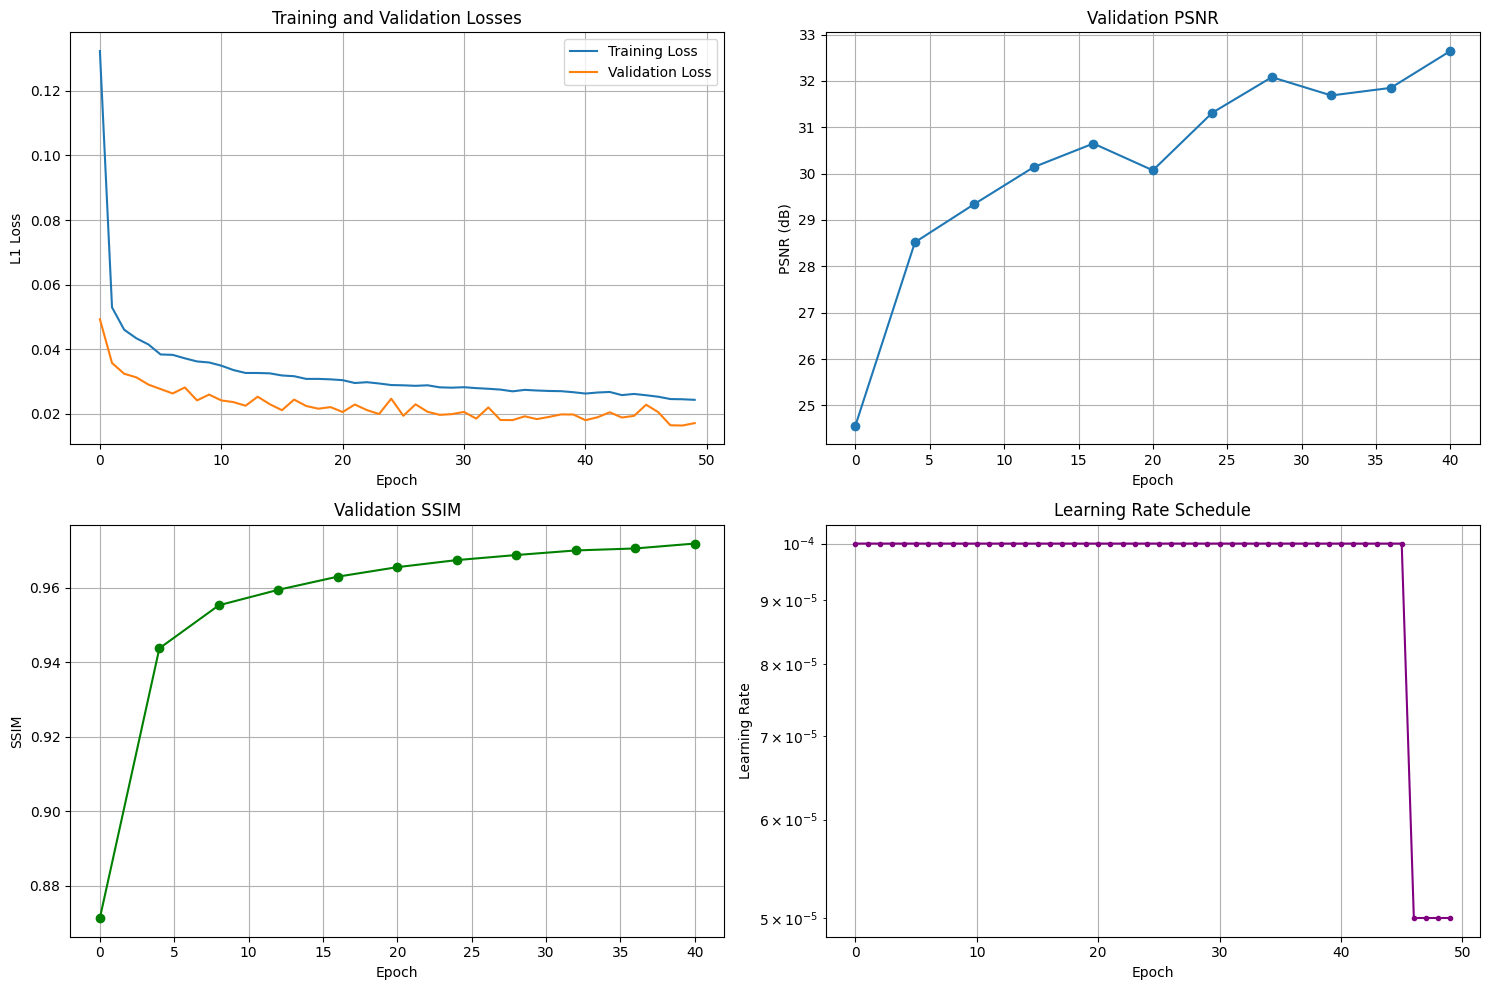

Checkpoint saved to ./models/final_model.pth
Model weights saved to ./models/model_weights.pth


In [ ]:
import copy
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import wandb
from torch.amp import GradScaler, autocast
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

# Set up environment
%matplotlib inline
DATA_DIR = 'SD1/train'  # Directory containing the dataset
OUTPUT_DIR = './models'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Training parameters
NUM_EPOCHS = 50
SAVE_EVERY = 10
EARLY_STOP_THRESHOLD = 0  # Target L1 loss threshold
EARLY_STOP_PATIENCE = 10 # ADDED: Patience for early stopping (default value)
LOG_IMAGES_EVERY = 5
BATCH_SIZE = 4
# LEARNING_RATE = 0.00010618302289321592
LEARNING_RATE = 0.0001
# WEIGHT_DECAY = 0.00000531178913994609
WEIGHT_DECAY = 1e-5
CLIP_GRAD_NORM = 1.0
IMAGE_SIZE = 512


# Initialize Weights & Biases
wandb.init(
    project="image-deglaring-sweep",  # Name of your project
    config={
        "model": "optimized",  # Model architecture
        "batch_size": BATCH_SIZE,  # Batch size
        "learning_rate": LEARNING_RATE,  # Learning rate
        "weight_decay": WEIGHT_DECAY,  # Weight decay
        "epochs": NUM_EPOCHS,  # Number of epochs
        "early_stop_threshold": EARLY_STOP_THRESHOLD,  # Early stopping threshold
        "early_stop_patience": EARLY_STOP_PATIENCE, # ADDED: Patience for early stopping to config
        "use_amp": torch.cuda.is_available(),  # Use mixed precision if available
        "clip_grad_norm": CLIP_GRAD_NORM,  # Gradient clipping value
        "image_size": IMAGE_SIZE  # Image size
    }
)

# Training Setup
# ==============

# Load Data
train_loader, val_loader = create_dataloaders(
    data_dir=DATA_DIR, # Ensure this path leads to the same files as scripts
    batch_size=BATCH_SIZE, # Use your notebook's BATCH_SIZE
    val_split=0.2, # Match script
    num_workers=4, # Match script/config
    seed=SEED,     # Use your global SEED
    image_size=IMAGE_SIZE, # Use your notebook's IMAGE_SIZE
    cache_images=False, # Match script default
    prefetch_factor=2, # Match script default
    persistent_workers=True # Match script default (if num_workers > 0)
)

# Define loss function
criterion = nn.L1Loss()

# Define optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999),
    eps=1e-8
)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Initialize for mixed precision training
scaler = GradScaler() if torch.cuda.is_available() else None
use_amp = torch.cuda.is_available()

# Initialize for tracking best model
best_val_loss = float('inf')
best_model_weights = None
epochs_no_improve = 0  # ADDED: Counter for epochs without improvement
patience_value = wandb.config.get("early_stop_patience", EARLY_STOP_PATIENCE) # ADDED: Get patience from config or use default

# Initialize tracking metrics
train_losses = []
val_losses = []
val_psnrs = []
val_ssims = []
lrs = []

# Log model architecture to wandb
wandb.watch(model, log="all", log_freq=500)
wandb.log({
    "model_summary": str(model),
    "model_parameters": sum(p.numel() for p in model.parameters() if p.requires_grad),
    "model_size_mb": get_model_size_mb(model)
})

# Function to log images to wandb
def log_images_to_wandb(inputs, outputs, targets, max_images=2):
    """Log input, output, and target images to Weights & Biases"""
    images = []
    num_images = min(max_images, inputs.size(0))

    for i in range(num_images):
        # Get images from batch and move to CPU
        input_img = inputs[i, 0].cpu().numpy()
        output_img = outputs[i, 0].detach().cpu().numpy()
        target_img = targets[i, 0].cpu().numpy()

        # Create wandb Image objects
        images.append(wandb.Image(
            input_img,
            caption=f"Input {i}",
            grouping=i
        ))

        images.append(wandb.Image(
            output_img,
            caption=f"Prediction {i}",
            grouping=i
        ))

        images.append(wandb.Image(
            target_img,
            caption=f"Ground Truth {i}",
            grouping=i
        ))

    # Log images to wandb
    wandb.log({"sample_images": images})

# Utility Functions for Training
# ==============================
def calculate_metrics(outputs, targets):
    """Calculate PSNR and SSIM metrics for validation"""
    # Process subset for efficiency
    subset_size = min(4, outputs.size(0))
    outputs = outputs[:subset_size]
    targets = targets[:subset_size]

    # Move to CPU and convert to numpy
    outputs_np = outputs.detach().cpu().numpy()
    targets_np = targets.detach().cpu().numpy()

    psnr_sum = 0
    ssim_sum = 0

    for i in range(subset_size):
        output_img = outputs_np[i, 0]
        target_img = targets_np[i, 0]

        # Calculate PSNR
        psnr = peak_signal_noise_ratio(target_img, output_img, data_range=1.0)
        psnr_sum += psnr

        # Calculate SSIM
        ssim = structural_similarity(target_img, output_img, data_range=1.0)
        ssim_sum += ssim

    return psnr_sum / subset_size, ssim_sum / subset_size

def save_model(model, optimizer, epoch, loss, output_dir, filename):
    """Save model checkpoint"""
    os.makedirs(output_dir, exist_ok=True)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, os.path.join(output_dir, filename))
    print(f"Checkpoint saved to {os.path.join(output_dir, filename)}")

    # Log model checkpoint to wandb
    wandb.save(os.path.join(output_dir, filename))

def plot_training_progress(train_losses, val_losses, val_psnrs, val_ssims, lrs):
    """Plot training progress metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot training and validation losses
    axes[0, 0].plot(train_losses, label='Training Loss')
    axes[0, 0].plot(val_losses, label='Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('L1 Loss')
    axes[0, 0].set_title('Training and Validation Losses')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Plot PSNR
    if val_psnrs:
        epochs = list(range(0, len(val_losses), len(val_losses)//len(val_psnrs)))[:len(val_psnrs)]
        axes[0, 1].plot(epochs, val_psnrs, marker='o')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('PSNR (dB)')
        axes[0, 1].set_title('Validation PSNR')
        axes[0, 1].grid(True)

    # Plot SSIM
    if val_ssims:
        epochs = list(range(0, len(val_losses), len(val_losses)//len(val_ssims)))[:len(val_ssims)]
        axes[1, 0].plot(epochs, val_ssims, marker='o', color='green')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('SSIM')
        axes[1, 0].set_title('Validation SSIM')
        axes[1, 0].grid(True)

    # Plot Learning Rate
    axes[1, 1].plot(lrs, marker='.', color='purple')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    # Save the plot
    fig.savefig(os.path.join(OUTPUT_DIR, 'loss_plot.png'))

# Training Loop
# =============
print("\n## Model Training Process")
print("Training the model with the following setup:")
print(f"- L1 Loss as required in the assessment")
print(f"- Target validation loss < {EARLY_STOP_THRESHOLD}")
print(f"- Early stopping when target loss is reached")
print(f"- AdamW optimizer")
print(f"- ReduceLROnPlateau learning rate scheduler")
if use_amp:
    print(f"- Automatic Mixed Precision for faster training")
print(f"- Gradient clipping for training stability")
print(f"- Weights & Biases for experiment tracking")

# Training loop
for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")

    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)

        # Zero the parameter gradients
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (for CUDA)
        if use_amp:
            with autocast(device_type=device.type):
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            # Backward pass with gradient scaling
            scaler.scale(loss).backward()

            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Step optimizer and update scaler
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard forward/backward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Optimizer step
            optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_psnr = 0.0
    val_ssim = 0.0
    calculate_metrics_this_epoch = (epoch + 1) % 5 == 0 or epoch == 0 or epoch == NUM_EPOCHS - 1
    log_images_this_epoch = (epoch + 1) % LOG_IMAGES_EVERY == 0 or epoch == 0 or epoch == NUM_EPOCHS - 1

    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Valid]")

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

            # Calculate image quality metrics only periodically
            if calculate_metrics_this_epoch:
                psnr, ssim = calculate_metrics(outputs, targets)
                val_psnr += psnr
                val_ssim += ssim

            # Log sample images for the first batch periodically
            if log_images_this_epoch and batch_idx == 0:
                log_images_to_wandb(inputs, outputs, targets)

            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    if calculate_metrics_this_epoch:
        val_psnr = val_psnr / len(val_loader)
        val_ssim = val_ssim / len(val_loader)
        val_psnrs.append(val_psnr)
        val_ssims.append(val_ssim)

    # Update learning rate with scheduler
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    lrs.append(current_lr)

    # Print metrics based on whether we calculated them this epoch
    if calculate_metrics_this_epoch:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"PSNR: {val_psnr:.2f}, SSIM: {val_ssim:.4f}, LR: {current_lr:.6f}")
    else:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"LR: {current_lr:.6f}")

    # Log metrics to wandb
    log_dict = {
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "learning_rate": current_lr
    }

    # Only add metrics if we calculated them
    if calculate_metrics_this_epoch:
        log_dict["val_psnr"] = val_psnr
        log_dict["val_ssim"] = val_ssim

    wandb.log(log_dict)

    # Save checkpoint periodically
    if (epoch + 1) % SAVE_EVERY == 0:
        save_model(
            model, optimizer, epoch, val_loss, OUTPUT_DIR,
            f'checkpoint_epoch_{epoch+1}.pth'
        )

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        save_model(
            model, optimizer, epoch, val_loss, OUTPUT_DIR,
            'best_model.pth'
        )
        print(f"New best model with validation loss: {val_loss:.4f}")

        # Log best model metrics to wandb summary
        wandb.run.summary["best_val_loss"] = best_val_loss
        if calculate_metrics_this_epoch:
            wandb.run.summary["best_val_psnr"] = val_psnr
            wandb.run.summary["best_val_ssim"] = val_ssim
        wandb.run.summary["best_epoch"] = epoch + 1

        epochs_no_improve = 0  # Reset patience counter

    else:
        epochs_no_improve += 1

    # Early stopping check
    if val_loss < EARLY_STOP_THRESHOLD:
        print(f"Early stopping at epoch {epoch+1} with validation loss {val_loss:.4f} < {EARLY_STOP_THRESHOLD}")
        break

    # Patience-based early stopping
    if epochs_no_improve >= patience_value:
        print(f"Early stopping: Validation loss did not improve for {patience_value} epochs.")
        if "best_epoch" in wandb.run.summary: # Check if best_epoch is available
            print(f"Stopping at epoch {epoch + 1}. Best validation loss: {best_val_loss:.4f} (achieved at epoch {wandb.run.summary['best_epoch']}).")
        else:
            print(f"Stopping at epoch {epoch + 1}. Best validation loss: {best_val_loss:.4f}.")
        break

# Load best model weights
model.load_state_dict(best_model_weights)
print(f"Training completed. Best validation loss: {best_val_loss:.4f}")

# Plot Training Results
# =====================
plot_training_progress(train_losses, val_losses, val_psnrs, val_ssims, lrs)

# Save Final Model
# ================
# Save final model in different formats
save_model(
    model, optimizer, NUM_EPOCHS, best_val_loss,
    OUTPUT_DIR, 'final_model.pth'
)

# Save model weights only (smaller file)
torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'model_weights.pth'))
print(f"Model weights saved to {os.path.join(OUTPUT_DIR, 'model_weights.pth')}")

# Finish wandb run
wandb.finish()

Epoch 1/50 [Train]: 100%|██████████| 2400/2400 [00:58<00:00, 40.97it/s, loss=0.0479]
Epoch 1/50 [Valid]: 100%|██████████| 600/600 [00:44<00:00, 13.37it/s, loss=0.1063]
Epoch 1/50: Train Loss: 0.1323, Val Loss: 0.0493, PSNR: 24.57, SSIM: 0.8713, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0493
Epoch 2/50 [Train]: 100%|██████████| 2400/2400 [00:58<00:00, 41.09it/s, loss=0.0358]
Epoch 2/50 [Valid]: 100%|██████████| 600/600 [00:23<00:00, 25.25it/s, loss=0.0752]
Epoch 2/50: Train Loss: 0.0529, Val Loss: 0.0357, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0357
Epoch 3/50 [Train]: 100%|██████████| 2400/2400 [00:58<00:00, 41.02it/s, loss=0.0224]
Epoch 3/50 [Valid]: 100%|██████████| 600/600 [00:23<00:00, 25.04it/s, loss=0.0814]
Epoch 3/50: Train Loss: 0.0460, Val Loss: 0.0324, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0324
Epoch 4/50 [Train]: 100%|██████████| 2400/2400 [00:58<00:00, 40.98it/s, loss=0.0929]
Epoch 4/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.95it/s, loss=0.0699]
Epoch 4/50: Train Loss: 0.0434, Val Loss: 0.0313, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0313
Epoch 5/50 [Train]: 100%|██████████| 2400/2400 [00:58<00:00, 40.81it/s, loss=0.0570]
Epoch 5/50 [Valid]: 100%|██████████| 600/600 [00:45<00:00, 13.13it/s, loss=0.0926]
Epoch 5/50: Train Loss: 0.0414, Val Loss: 0.0290, PSNR: 28.52, SSIM: 0.9438, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0290
Epoch 6/50 [Train]: 100%|██████████| 2400/2400 [00:58<00:00, 40.93it/s, loss=0.0433]
Epoch 6/50 [Valid]: 100%|██████████| 600/600 [00:23<00:00, 25.17it/s, loss=0.0523]
Epoch 6/50: Train Loss: 0.0384, Val Loss: 0.0276, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0276
Epoch 7/50 [Train]: 100%|██████████| 2400/2400 [00:58<00:00, 40.90it/s, loss=0.0333]
Epoch 7/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.70it/s, loss=0.0502]
Epoch 7/50: Train Loss: 0.0382, Val Loss: 0.0263, LR: 0.000100
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0263
Epoch 8/50 [Train]: 100%|██████████| 2400/2400 [00:58<00:00, 40.75it/s, loss=0.0313]
Epoch 8/50 [Valid]: 100%|██████████| 600/600 [00:24<00:00, 24.86it/s, loss=0.1531]
Epoch 8/50: Train Loss: 0.0372, Val Loss: 0.0281, LR: 0.000100


Epoch 1/50 [Train]: 100%|██████████| 2530/2530 [02:32<00:00, 16.62it/s, loss=0.0561]
Epoch 1/50 [Valid]: 100%|██████████| 633/633 [01:04<00:00,  9.82it/s, loss=0.1954]
Epoch 1/50: Train Loss: 0.0990, Val Loss: 0.0650, PSNR: 22.16, SSIM: 0.8406, LR: 0.000106
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0650
Epoch 2/50 [Train]: 100%|██████████| 2530/2530 [02:31<00:00, 16.69it/s, loss=0.0479]
Epoch 2/50 [Valid]: 100%|██████████| 633/633 [00:30<00:00, 21.06it/s, loss=0.1206]
Epoch 2/50: Train Loss: 0.0675, Val Loss: 0.0478, LR: 0.000106
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0478
Epoch 3/50 [Train]: 100%|██████████| 2530/2530 [02:32<00:00, 16.63it/s, loss=0.0533]
Epoch 3/50 [Valid]: 100%|██████████| 633/633 [00:29<00:00, 21.72it/s, loss=0.0603]
Epoch 3/50: Train Loss: 0.0594, Val Loss: 0.0474, LR: 0.000106
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0474
Epoch 4/50 [Train]: 100%|██████████| 2530/2530 [02:31<00:00, 16.65it/s, loss=0.0352]
Epoch 4/50 [Valid]: 100%|██████████| 633/633 [00:29<00:00, 21.70it/s, loss=0.0668]
Epoch 4/50: Train Loss: 0.0562, Val Loss: 0.0429, LR: 0.000106
Checkpoint saved to ./models/best_model.pth
New best model with validation loss: 0.0429

# Inference on Validation Set


## Model Inference Demonstration


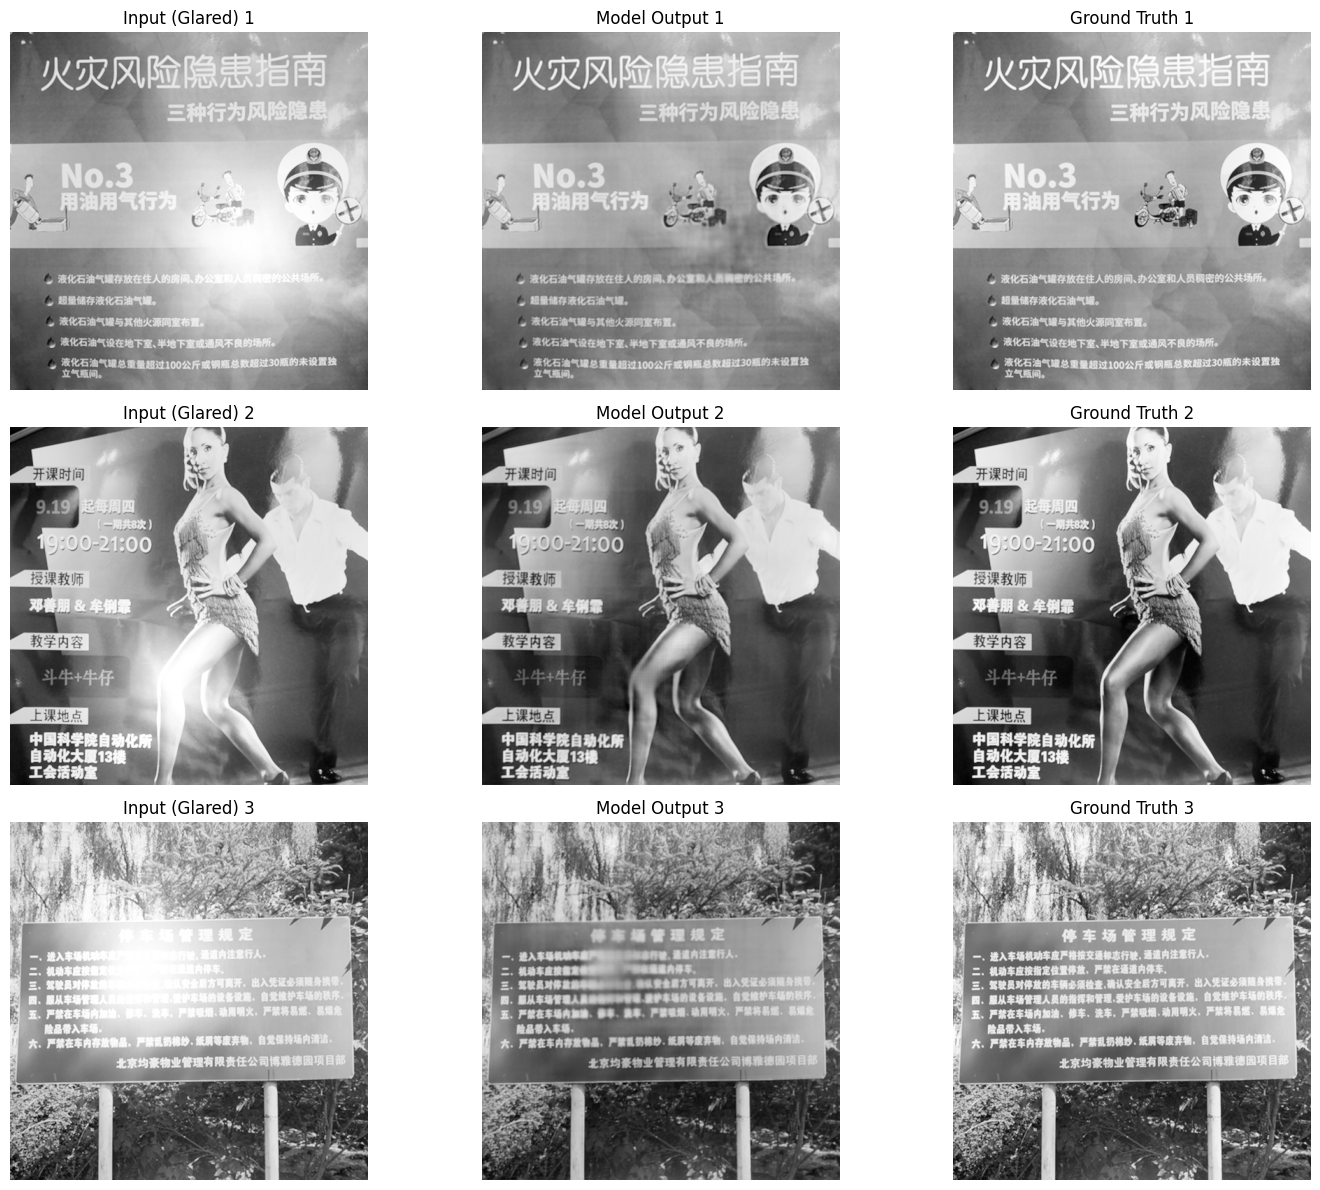

PSNR: 30.09 dB
SSIM: 0.9647
L1 Loss: 0.0253

## Final Model Summary
Final model size: 1.86 MB
Success: Model meets the 4MB size requirement!
Final validation L1 loss: 0.0164
Success: Model achieved the target L1 loss of < 0.06!


In [22]:
# Inference Demo
# ===============
print("\n## Model Inference Demonstration")

# Get a batch from validation set
val_batch = next(iter(val_loader))
inputs, targets = val_batch
inputs = inputs.to(device)
targets = targets.to(device)

# Run inference
model.eval()
with torch.no_grad():
    outputs = model(inputs)

# Move tensors to CPU for visualization
inputs_cpu = inputs.cpu()
outputs_cpu = outputs.cpu()
targets_cpu = targets.cpu()

# Display results
def show_inference_results(inputs, outputs, targets, num_samples=3):
    plt.figure(figsize=(15, 4*num_samples))

    for i in range(num_samples):
        # Input image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(inputs[i, 0].numpy(), cmap='gray')
        plt.title(f"Input (Glared) {i+1}")
        plt.axis('off')

        # Output image (model prediction)
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(outputs[i, 0].numpy(), cmap='gray')
        plt.title(f"Model Output {i+1}")
        plt.axis('off')

        # Target image (ground truth)
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(targets[i, 0].numpy(), cmap='gray')
        plt.title(f"Ground Truth {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show inference results
show_inference_results(inputs_cpu, outputs_cpu, targets_cpu)

# Calculate and display metrics for the displayed samples
psnr, ssim = calculate_metrics(outputs_cpu, targets_cpu)
print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim:.4f}")
print(f"L1 Loss: {criterion(outputs_cpu, targets_cpu):.4f}")


# Model Size Summary
# ===================
print("\n## Final Model Summary")
print(f"Final model size: {get_model_size_mb(model):.2f} MB")
if get_model_size_mb(model) > 4.0:
    print("Warning: Model exceeds 4MB target size.")
else:
    print("Success: Model meets the 4MB size requirement!")

print(f"Final validation L1 loss: {best_val_loss:.4f}")
if best_val_loss < 0.06:
    print("Success: Model achieved the target L1 loss of < 0.06!")
else:
    print(f"Note: Model did not reach the target L1 loss of < 0.06. Further training may be needed.")

# Evaluation on Final Test Set
## (SD1/val folder)

In [23]:
import glob

def create_evaluation_dataloader(data_dir, batch_size, num_workers, image_size, seed):
    """
    Create dataloader for evaluation

    Args:
        data_dir (str): Directory containing validation images
        batch_size (int): Batch size for dataloader
        num_workers (int): Number of worker threads
        image_size (int): Size to resize images to
        seed (int): Random seed for reproducibility

    Returns:
        DataLoader: DataLoader for evaluation
    """
    # Get all image file paths from validation set
    image_paths = []
    for ext in ('*.png', '*.jpg', '*.jpeg'):
        image_paths.extend(glob.glob(os.path.join(data_dir, ext)))

    if not image_paths:
        raise ValueError(f"No images found in {data_dir}")

    print(f"Found {len(image_paths)} validation images in {data_dir}")

    # Get transformations (only validation transforms needed)
    _, val_transform = get_transformations(image_size)

    # Create dataset
    val_dataset = GlareRemovalDataset(
        image_paths,
        transform=val_transform,
        seed=seed,
        image_size=image_size,
        cache_images=False
    )

    # Create dataloader
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return val_loader

def evaluate(model, val_loader, device, save_visualizations=False,
           visualizations_dir=None, max_vis_samples=10):
    """
    Evaluate model on validation set

    Args:
        model (nn.Module): Model to evaluate
        val_loader (DataLoader): Validation data loader
        device (torch.device): Device to run evaluation on
        save_visualizations (bool): Whether to save visualization of predictions
        visualizations_dir (str): Directory to save visualizations
        max_vis_samples (int): Maximum number of samples to visualize

    Returns:
        dict: Dictionary containing evaluation metrics
    """
    # Prepare for evaluation
    model.eval()
    criterion = nn.L1Loss()
    total_loss = 0.0
    total_psnr = 0.0
    total_ssim = 0.0
    num_batches = len(val_loader)

    # Create directory for visualizations if needed
    if save_visualizations and visualizations_dir:
        os.makedirs(visualizations_dir, exist_ok=True)

    # Counter for visualization samples
    vis_count = 0

    print("Starting evaluation...")
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(val_loader, desc="Evaluating")):
            # Move to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            outputs_min = outputs.min().item()
            outputs_max = outputs.max().item()
            # print(f"[Batch {batch_idx}] Output tensor range: min={outputs_min:.4f}, max={outputs_max:.4f}")

            # Calculate L1 loss
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # Calculate additional metrics (on CPU for skimage functions)
            outputs_np = outputs.detach().cpu().numpy()
            targets_np = targets.detach().cpu().numpy()

            # Calculate metrics for each image in batch
            for i in range(inputs.size(0)):
                output_img = outputs_np[i, 0]  # [H, W]
                target_img = targets_np[i, 0]  # [H, W]

                # Ensure correct range for metrics (0 to 1)
                output_img = np.clip(output_img, 0, 1)

                # Calculate PSNR
                psnr = peak_signal_noise_ratio(target_img, output_img, data_range=1.0)
                total_psnr += psnr

                # Calculate SSIM
                ssim = structural_similarity(target_img, output_img, data_range=1.0)
                total_ssim += ssim

                # Save visualizations for a few samples
                if save_visualizations and vis_count < max_vis_samples:
                    input_img = inputs.cpu().numpy()[i, 0]  # [H, W]

                    plt.figure(figsize=(15, 5))

                    plt.subplot(1, 3, 1)
                    plt.imshow(input_img, cmap='gray')
                    input_min = input_img.min()
                    input_max = input_img.max()
                    plt.title(f'Input\nRange: [{input_min:.2f}, {input_max:.2f}]')
                    plt.axis('off')

                    plt.subplot(1, 3, 2)
                    plt.imshow(output_img, cmap='gray')
                    output_min = output_img.min()
                    output_max = output_img.max()
                    plt.title(f'Prediction\nPSNR: {psnr:.2f}, SSIM: {ssim:.4f}\nRange: [{output_min:.2f}, {output_max:.2f}]')
                    plt.axis('off')

                    plt.subplot(1, 3, 3)
                    plt.imshow(target_img, cmap='gray')
                    target_min = target_img.min()
                    target_max = target_img.max()
                    plt.title(f'Ground Truth\nRange: [{target_min:.2f}, {target_max:.2f}]')
                    plt.axis('off')

                    plt.tight_layout()
                    plt.savefig(os.path.join(visualizations_dir, f'sample_{vis_count}.png'))
                    plt.close()

                    vis_count += 1

    # Calculate average metrics
    total_samples = len(val_loader.dataset)
    avg_loss = total_loss / num_batches
    avg_psnr = total_psnr / total_samples
    avg_ssim = total_ssim / total_samples

    # Print metrics
    print(f"Evaluation on {total_samples} samples:")
    print(f"L1 Loss: {avg_loss:.4f}")
    print(f"PSNR: {avg_psnr:.2f} dB")
    print(f"SSIM: {avg_ssim:.4f}")

    # Return metrics as dictionary
    return {
        'l1_loss': avg_loss,
        'psnr': avg_psnr,
        'ssim': avg_ssim
    }


In [24]:
# Set random seed for reproducibility
set_seed(SEED)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# Create evaluation dataloader
val_loader = create_evaluation_dataloader(
    data_dir="SD1/val",
    batch_size=4,
    num_workers=4,
    image_size=512,
    seed=SEED
)

# Evaluate model
metrics = evaluate(
    model,
    val_loader,
    device,
    save_visualizations=True,
    visualizations_dir='./eval_visualizations',
    max_vis_samples=10
)

# Save metrics to file
with open('./evaluation_results.txt', 'w') as f:
    f.write(f"Evaluation results on SD1/val:\n")
    f.write(f"L1 Loss: {metrics['l1_loss']:.4f}\n")
    f.write(f"PSNR: {metrics['psnr']:.2f} dB\n")
    f.write(f"SSIM: {metrics['ssim']:.4f}\n")

print(f"Evaluation completed. Results saved to ./evaluation_results.txt")

All random seeds set to 42 for reproducibility
Using device: cuda
Found 650 validation images in SD1/val
Starting evaluation...


Evaluating: 100%|██████████| 163/163 [00:15<00:00, 10.42it/s]

Evaluation on 650 samples:
L1 Loss: 0.0168
PSNR: 32.57 dB
SSIM: 0.9750
Evaluation completed. Results saved to ./evaluation_results.txt


# Conclusion
The final Weights and Biases report is available at: [Image De-glaring Report](https://wandb.ai/jooz-cave/image-deglaring-sweep/reports/Image-De-glaring---VmlldzoxMjg0MTExMw?accessToken=npyx1xtj55rqrp8lqvzuauc3uur79os9udklwnustgslmelvqld3vqhlrn0amz61)